In [1]:
import os
os.environ['JAVA_TOOL_OPTIONS'] = '-Djava.security.manager=allow'

In [2]:
# =================== 1. Setup Spark and Import Libraries ===================
from pyspark.sql import SparkSession
from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor, LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
import argparse
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import *
from pyspark.ml.classification import *
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import *
import json
from pyspark.sql.functions import col, isnan, when, count
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# Initialize Spark Session
spark = SparkSession.builder.appName("MachineLearningProject").getOrCreate()

Picked up JAVA_TOOL_OPTIONS: -Djava.security.manager=allow
Picked up JAVA_TOOL_OPTIONS: -Djava.security.manager=allow
25/01/06 14:21:08 WARN Utils: Your hostname, Mariajoses-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.17 instead (on interface en0)
25/01/06 14:21:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/06 14:21:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# =================== 1. Data Reading ===================
def load_data(spark, mode):
    """
    Load the input dataset, drop forbidden columns, and validate its structure.

    Args:
        spark (SparkSession): The active Spark session.
        input_path (str): Path to the input CSV file.
        mode (str): Mode of operation ("train" or "predict").

    Returns:
        DataFrame: Processed Spark DataFrame.
    """

    processed_schema_path = './data/processed/schema.json'
    processed_test_path_parquet = './data/processed/test.parquet'
    processed_train_path_parquet = './data/processed/train.parquet'

    try:
        # Read the dataset
        with open(processed_schema_path, 'r') as f:
            schema_json = f.read()

            schema = StructType.fromJson(json.loads(schema_json))

            test_df = spark.read.parquet(processed_test_path_parquet, schema=schema)
            train_df = spark.read.parquet(processed_train_path_parquet, schema=schema)

        # Check if the dataset is empty
        if train_df.count() == 0:
            raise ValueError("The dataset is empty.")

        # Validate the presence of the target variable for training
        if mode == "train" and "ArrDelay" not in train_df.columns:
            raise ValueError("The target variable 'ArrDelay' is missing.")

    except Exception as e:
        print(f"Error reading the dataset: {e}")
        spark.stop()
        raise

    return train_df, test_df, schema


In [4]:
train_df, test_df, schema = load_data(spark, 'train')

In [5]:
numeric_features = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSElapsedTime', 'ArrDelay', 'DepDelay', 'Distance', 'TaxiOut', 'DepTime_minutes', 'CRSDepTime_minutes', 'CRSArrTime_minutes', 'Month_cos', 'Month_sin', 'DayofMonth_cos', 'DayofMonth_sin', 'DayOfWeek_cos', 'DayOfWeek_sin']
categorical_features = ['Origin', 'Dest', 'Manufacturer', 'Model', 'AircraftType', 'EngineType', 'PlaneIssueYear']
binary_features = ['EngineType_binary', 'AircraftType_binary', 'Manufacturer_binary', 'Model_binary', 'Year_binary', 'PlaneIssueYear_binary', 'Origin_binary', 'Dest_binary']

In [6]:
print(f"Number of rows: {train_df.count()}")
print(f"Number of columns: {len(train_df.columns)}")

Number of rows: 1791742
Number of columns: 37


In [7]:
def null_values(data, features_list):
    null_data = data.select(features_list).select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in data.select(features_list).columns])
    null_data.show()

In [8]:
null_values(train_df, numeric_features)

+----+-----+----------+---------+--------------+--------+--------+--------+-------+---------------+------------------+------------------+---------+---------+--------------+--------------+-------------+-------------+
|Year|Month|DayofMonth|DayOfWeek|CRSElapsedTime|ArrDelay|DepDelay|Distance|TaxiOut|DepTime_minutes|CRSDepTime_minutes|CRSArrTime_minutes|Month_cos|Month_sin|DayofMonth_cos|DayofMonth_sin|DayOfWeek_cos|DayOfWeek_sin|
+----+-----+----------+---------+--------------+--------+--------+--------+-------+---------------+------------------+------------------+---------+---------+--------------+--------------+-------------+-------------+
|   0|    0|         0|        0|             0|    4303|       0|       0|      0|              0|                 0|                 0|        0|        0|             0|             0|            0|            0|
+----+-----+----------+---------+--------------+--------+--------+--------+-------+---------------+------------------+------------------

There are 4303 null values in the ARRDelay feature

In [9]:
null_values(train_df, categorical_features)

+------+----+------------+-----+------------+----------+--------------+
|Origin|Dest|Manufacturer|Model|AircraftType|EngineType|PlaneIssueYear|
+------+----+------------+-----+------------+----------+--------------+
|     0|   0|           0|    0|           0|         0|             0|
+------+----+------------+-----+------------+----------+--------------+



There is no null values in the categorical features

We are going to remove the records that have null values in the ArrDelay variable

In [10]:
train_df = train_df.dropna(subset=["ArrDelay"])

print(f"Number of rows: { train_df.count()}")
print(f"Number of columns: {len( train_df.columns)}")

Number of rows: 1787439
Number of columns: 37


## **Statistics Summary**

In [11]:
def statistics_summary(data):
    summary_df = data.select(numeric_features).summary().toPandas()
    summary_df.set_index("summary", inplace=True)
    summary_numeric = summary_df.apply(pd.to_numeric, errors='coerce')
    summary_numeric = summary_numeric.T
    return summary_numeric

In [12]:
summary = statistics_summary(train_df)
summary

25/01/06 14:21:46 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/01/06 14:21:53 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


summary,count,mean,stddev,min,25%,50%,75%,max
Year,1787439.0,2008.000000,0.000000,2008.000000,2008.000000,2.008000e+03,2008.000000,2008.000000
Month,1787439.0,2.511085,1.123554,1.000000,1.000000,3.000000e+00,4.000000,4.000000
DayofMonth,1787439.0,15.697609,8.744607,1.000000,8.000000,1.600000e+01,23.000000,31.000000
DayOfWeek,1787439.0,3.915028,1.982248,1.000000,2.000000,4.000000e+00,6.000000,7.000000
CRSElapsedTime,1787439.0,130.771771,70.563761,-21.000000,80.000000,1.130000e+02,162.000000,660.000000
ArrDelay,1787439.0,10.278516,39.523007,-91.000000,-9.000000,0.000000e+00,15.000000,2461.000000
DepDelay,1787439.0,11.366037,36.297312,-92.000000,-4.000000,0.000000e+00,11.000000,2467.000000
Distance,1787439.0,740.182515,565.275273,30.000000,329.000000,5.900000e+02,984.000000,4962.000000
TaxiOut,1787439.0,16.582283,11.008364,0.000000,10.000000,1.400000e+01,19.000000,379.000000
DepTime_minutes,1787439.0,1946.442120,1660.977867,600.000000,839.000000,1.080000e+03,3604.000000,5709.000000


## **Features Distribution**

In [13]:
def features_distributions(data, features_list, is_numeric_features=True):
    if is_numeric_features == True:
        numerical_df = data.select(features_list).toPandas()

        num_features = len(features_list)
        cols = 3  # Number of columns in the grid
        rows = (num_features // cols) + (num_features % cols > 0)  # Calculate rows needed

        fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))  # Adjust the figure size
        axes = axes.flatten()  # Flatten the axes array for easy iteration

        # Plot each feature's distribution
        for i, col in enumerate(features_list):
            sns.histplot(numerical_df[col], bins=30, ax=axes[i])  # Use the subplot's axis
            axes[i].set_title(f"Distribution of {col}")
            axes[i].set_xlabel(col)
            axes[i].set_ylabel("Frequency")

        # Remove any unused subplots
        for i in range(len(features_list), len(axes)):
            fig.delaxes(axes[i])

        plt.tight_layout()  # Adjust layout to avoid overlap
        plt.show()
    else:
        num_features = len(features_list)
        cols = 2  # Number of columns in the grid
        rows = (num_features // cols) + (num_features % cols > 0)  # Calculate rows needed

        fig, axes = plt.subplots(rows, cols, figsize=(10, rows * 5))  # Adjust figure size
        axes = axes.flatten()  # Flatten the axes array for easy iteration

        # Plot each feature's distribution
        for i, col in enumerate(features_list):
            # Group by column and count occurrences
            # Limit to top 15 categories
            top_n = 15
            category_counts = data.groupBy(col).count().orderBy("count", ascending=False).limit(top_n)
            category_df = category_counts.toPandas()

            # Plot using the subplot axis
            sns.barplot(data=category_df, x=col, y="count", ax=axes[i])
            axes[i].set_title(f"Distribution of {col}")
            axes[i].set_xlabel(col)
            axes[i].set_ylabel("Count")
            axes[i].tick_params(axis="x", rotation=90)  # Rotate x-axis labels

        # Remove any unused subplots
        for i in range(len(features_list), len(axes)):
            fig.delaxes(axes[i])

        plt.tight_layout()  # Adjust layout to avoid overlap
        plt.show()

Numerical features:

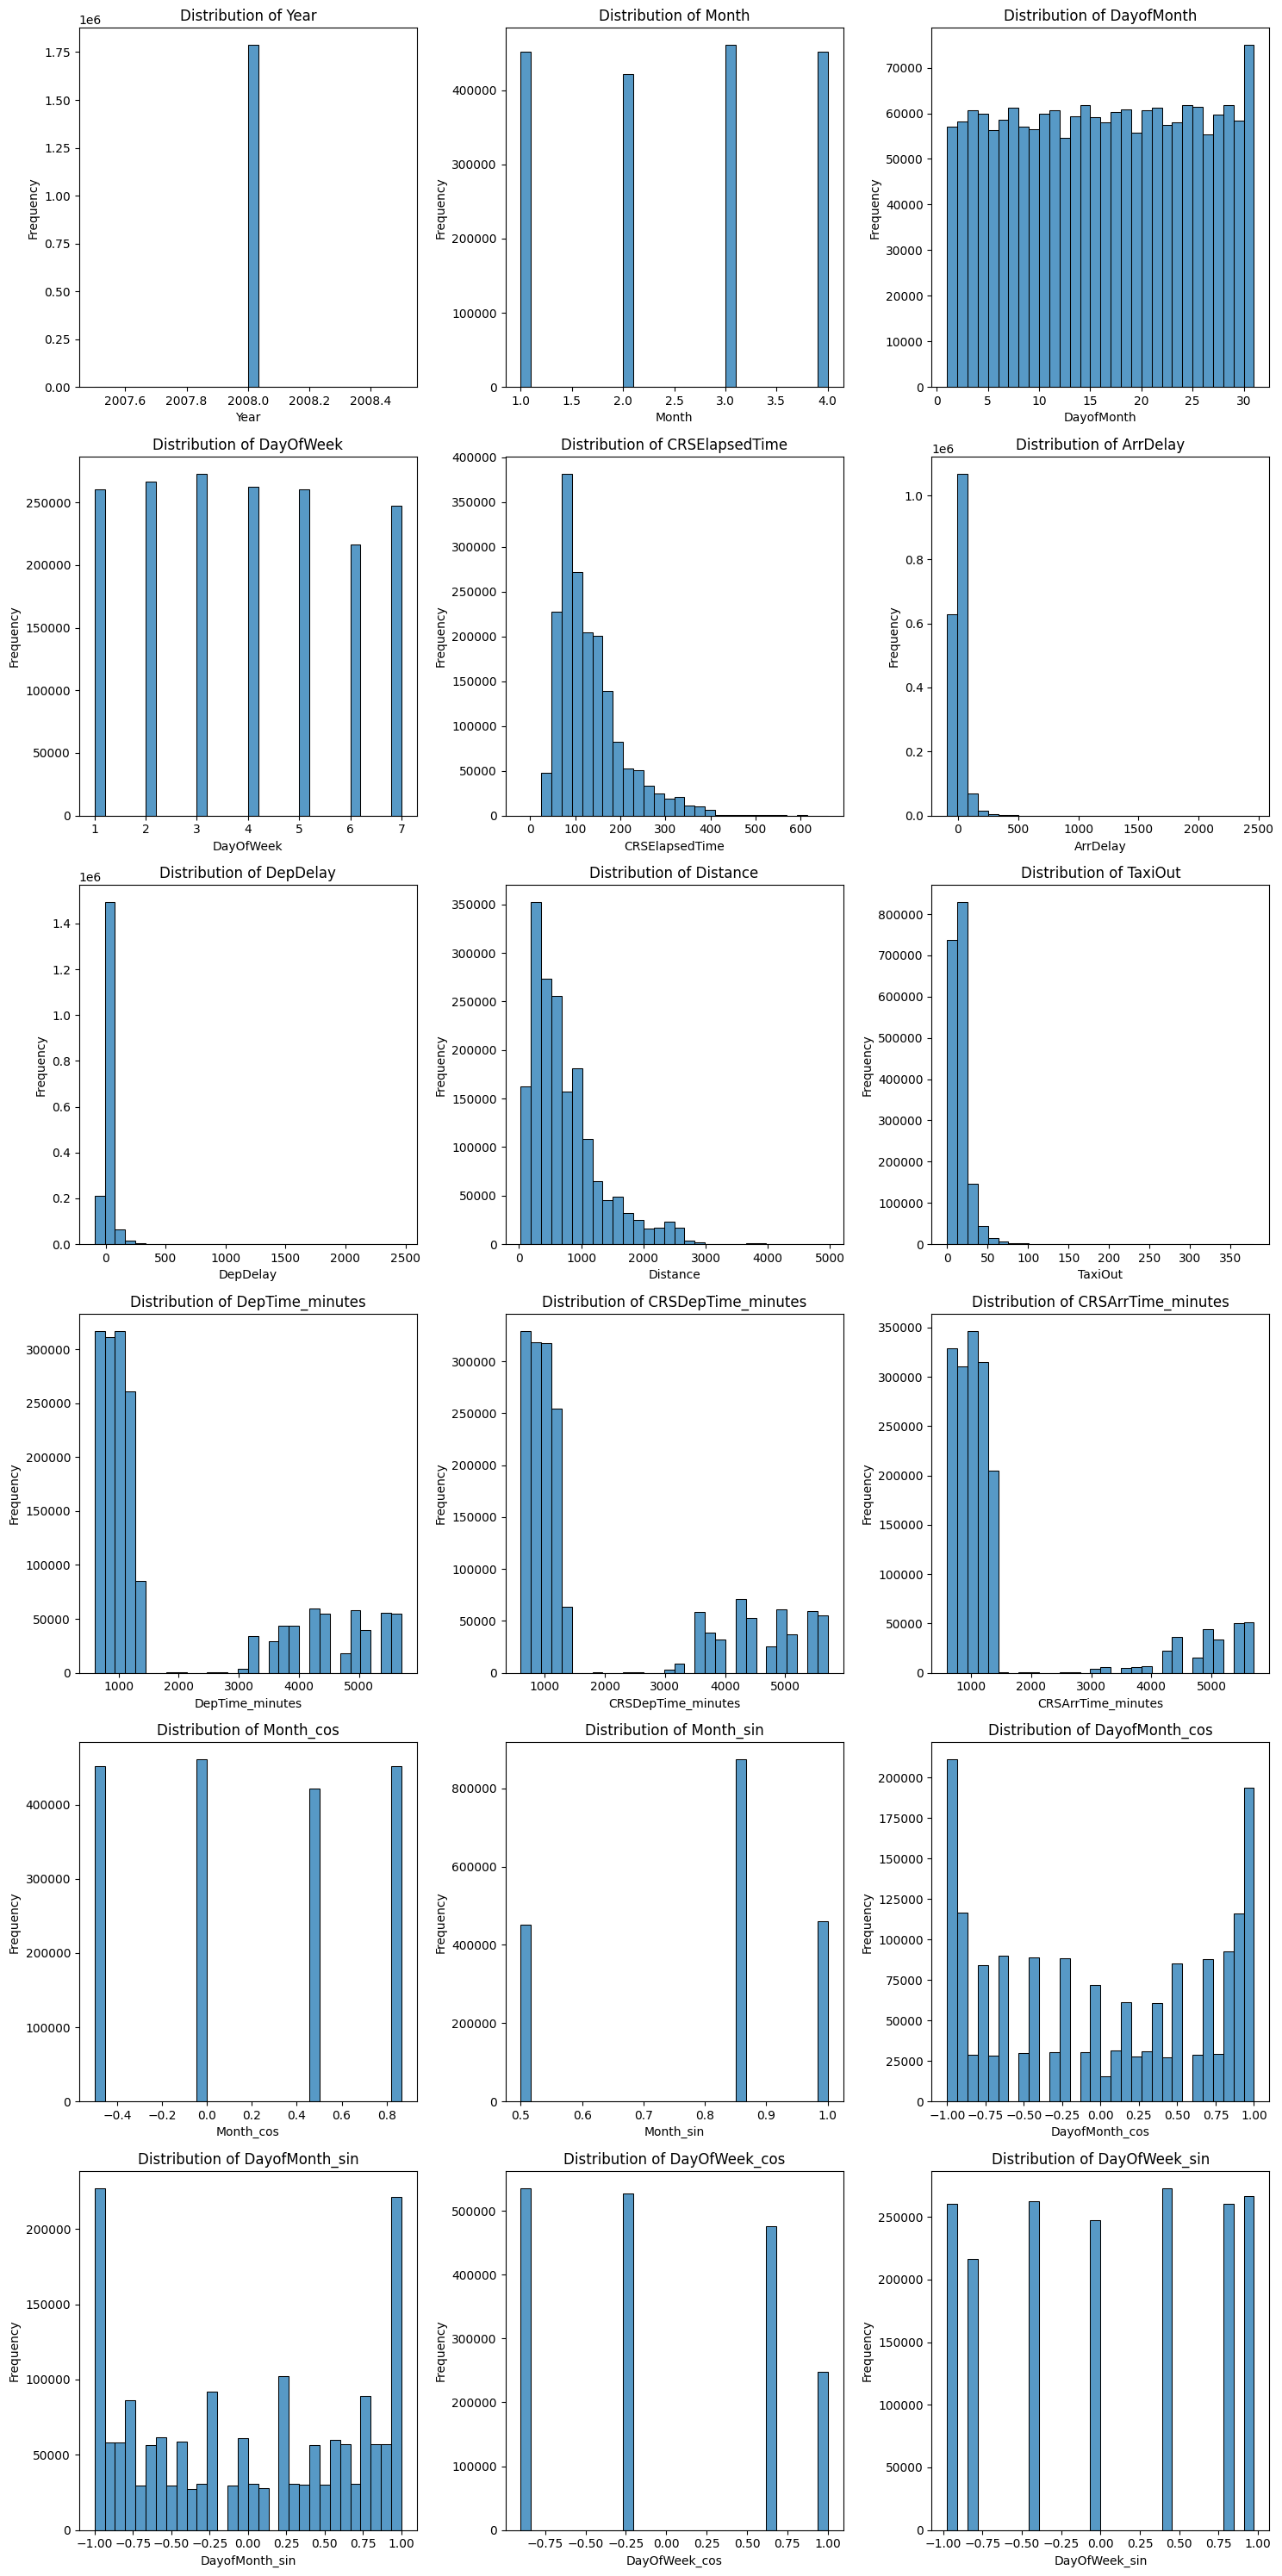

In [14]:
features_distributions(train_df, numeric_features, is_numeric_features=True)

Categorical features:

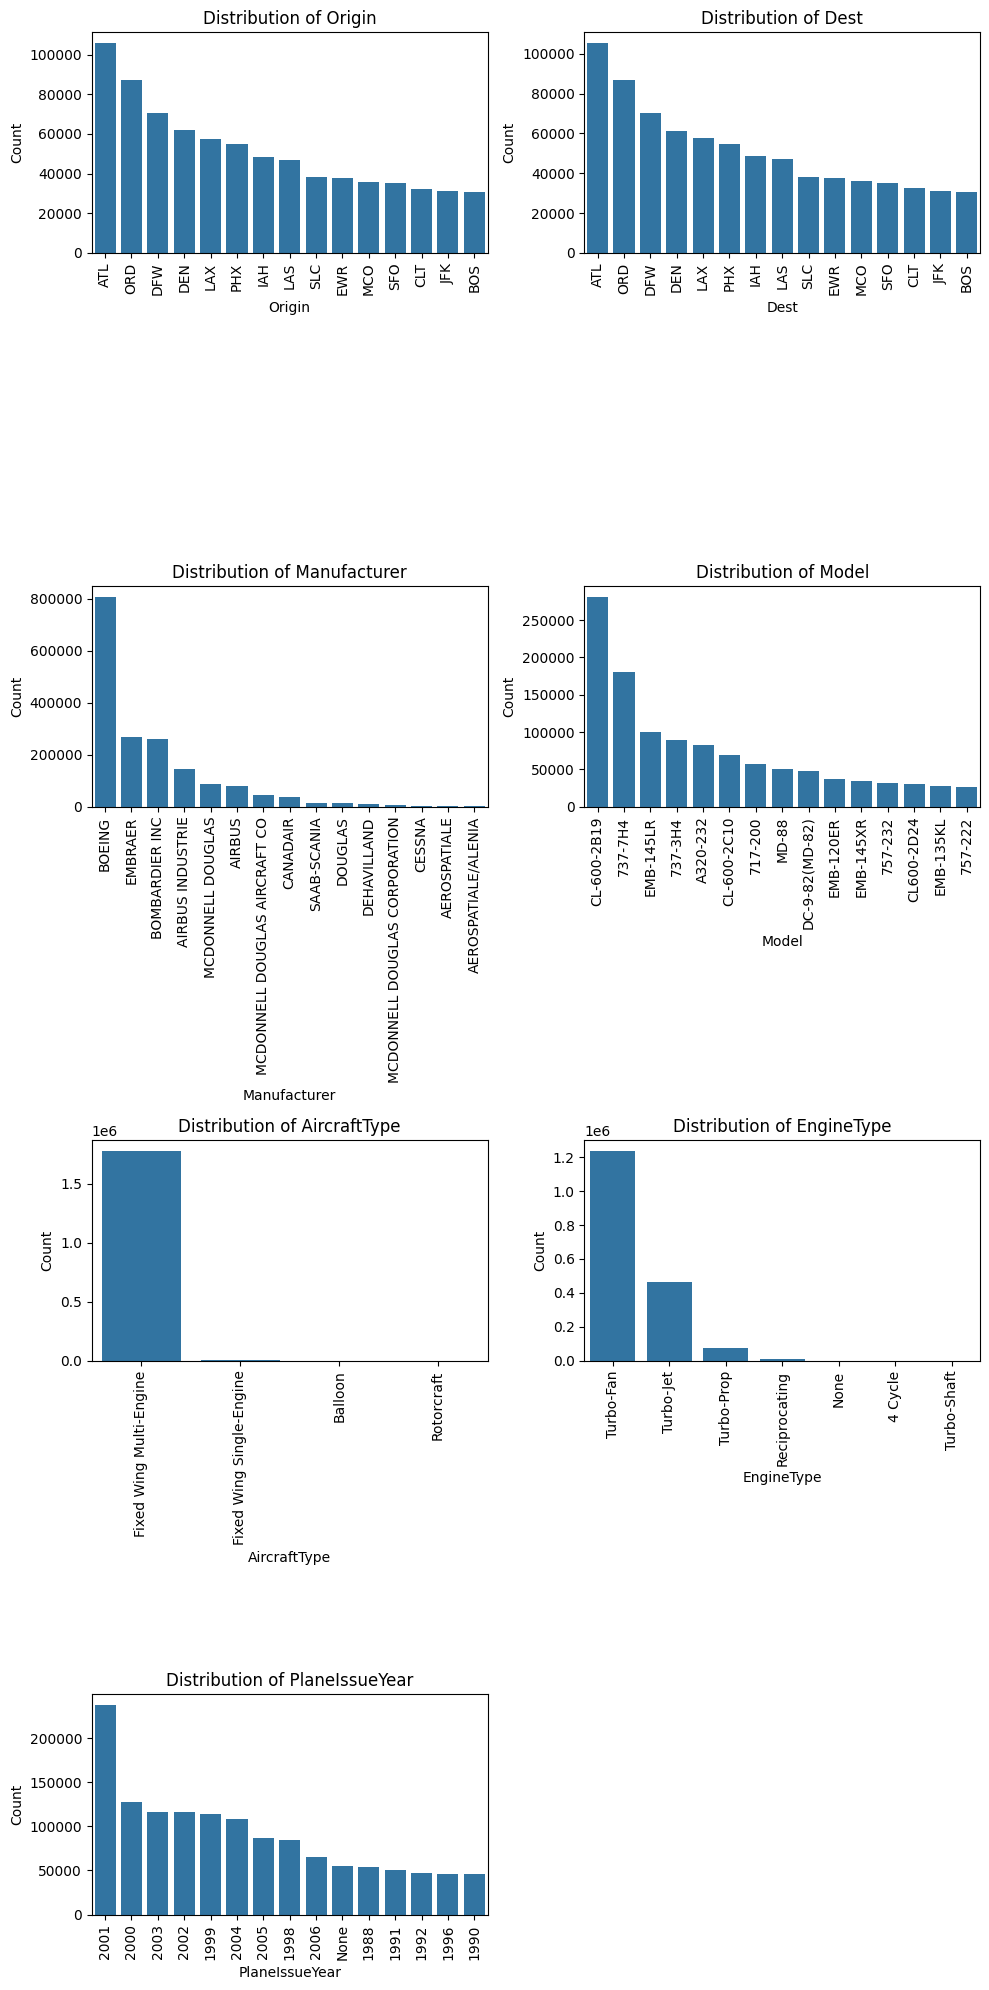

In [15]:
features_distributions(train_df, categorical_features, is_numeric_features=False)

## **Features Proportions**

In [16]:
def proportions(data, features_list, is_numeric_features = True):
    if is_numeric_features == True:
        type = 'numerical'
    else:
        type = 'categorical'

    total_count = data.count()
    for feature in features_list:
        feature_counts = train_df.groupBy(feature).count()
        # Calculate proportions
        feature_proportions = feature_counts.withColumn(
            "Proportion", round((col("count") / total_count)*100,2)
        )
        if not os.path.exists(f'output/{type}'):
            os.makedirs(f'output/{type}')
        feature_proportions.write.csv(f"output/{type}/{feature}_proportions.csv", header=True, mode="overwrite")

In [17]:
proportions(train_df, categorical_features, is_numeric_features=False)

In [18]:
proportions(train_df, numeric_features, is_numeric_features=True)

## **Average ArrDelay by categorical features**

In [19]:
def avg_ArrDelay(data, features_list):
    # Number of features
    num_features = len(features_list)
    cols = 2  # Number of columns in the grid
    rows = (num_features // cols) + (num_features % cols > 0)  # Calculate rows needed

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 6))  # Adjust figure size
    axes = axes.flatten()  # Flatten axes for easy iteration

    # Iterate over each categorical feature
    for i, col in enumerate(features_list):
        # Group data and calculate average arrival delay
        grouped_df = data.groupBy(col).agg({"ArrDelay": "mean"})

        # Convert to Pandas
        grouped_pandas = grouped_df.toPandas()

        # Plot bar chart in the subplot
        sns.barplot(data=grouped_pandas, x=col, y="avg(ArrDelay)", ax=axes[i])
        axes[i].set_title(f"Average Arrival Delay by {col}", fontsize=12)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Avg. Arrival Delay")
        axes[i].tick_params(axis="x", rotation=90)

    # Remove any unused subplots
    for i in range(len(features_list), len(axes)):
        fig.delaxes(axes[i])

    # Add a global title
    fig.suptitle("Average Arrival Delay by Categorical Features", fontsize=16, y=1.02)

    # Adjust layout
    plt.tight_layout()
    plt.show()

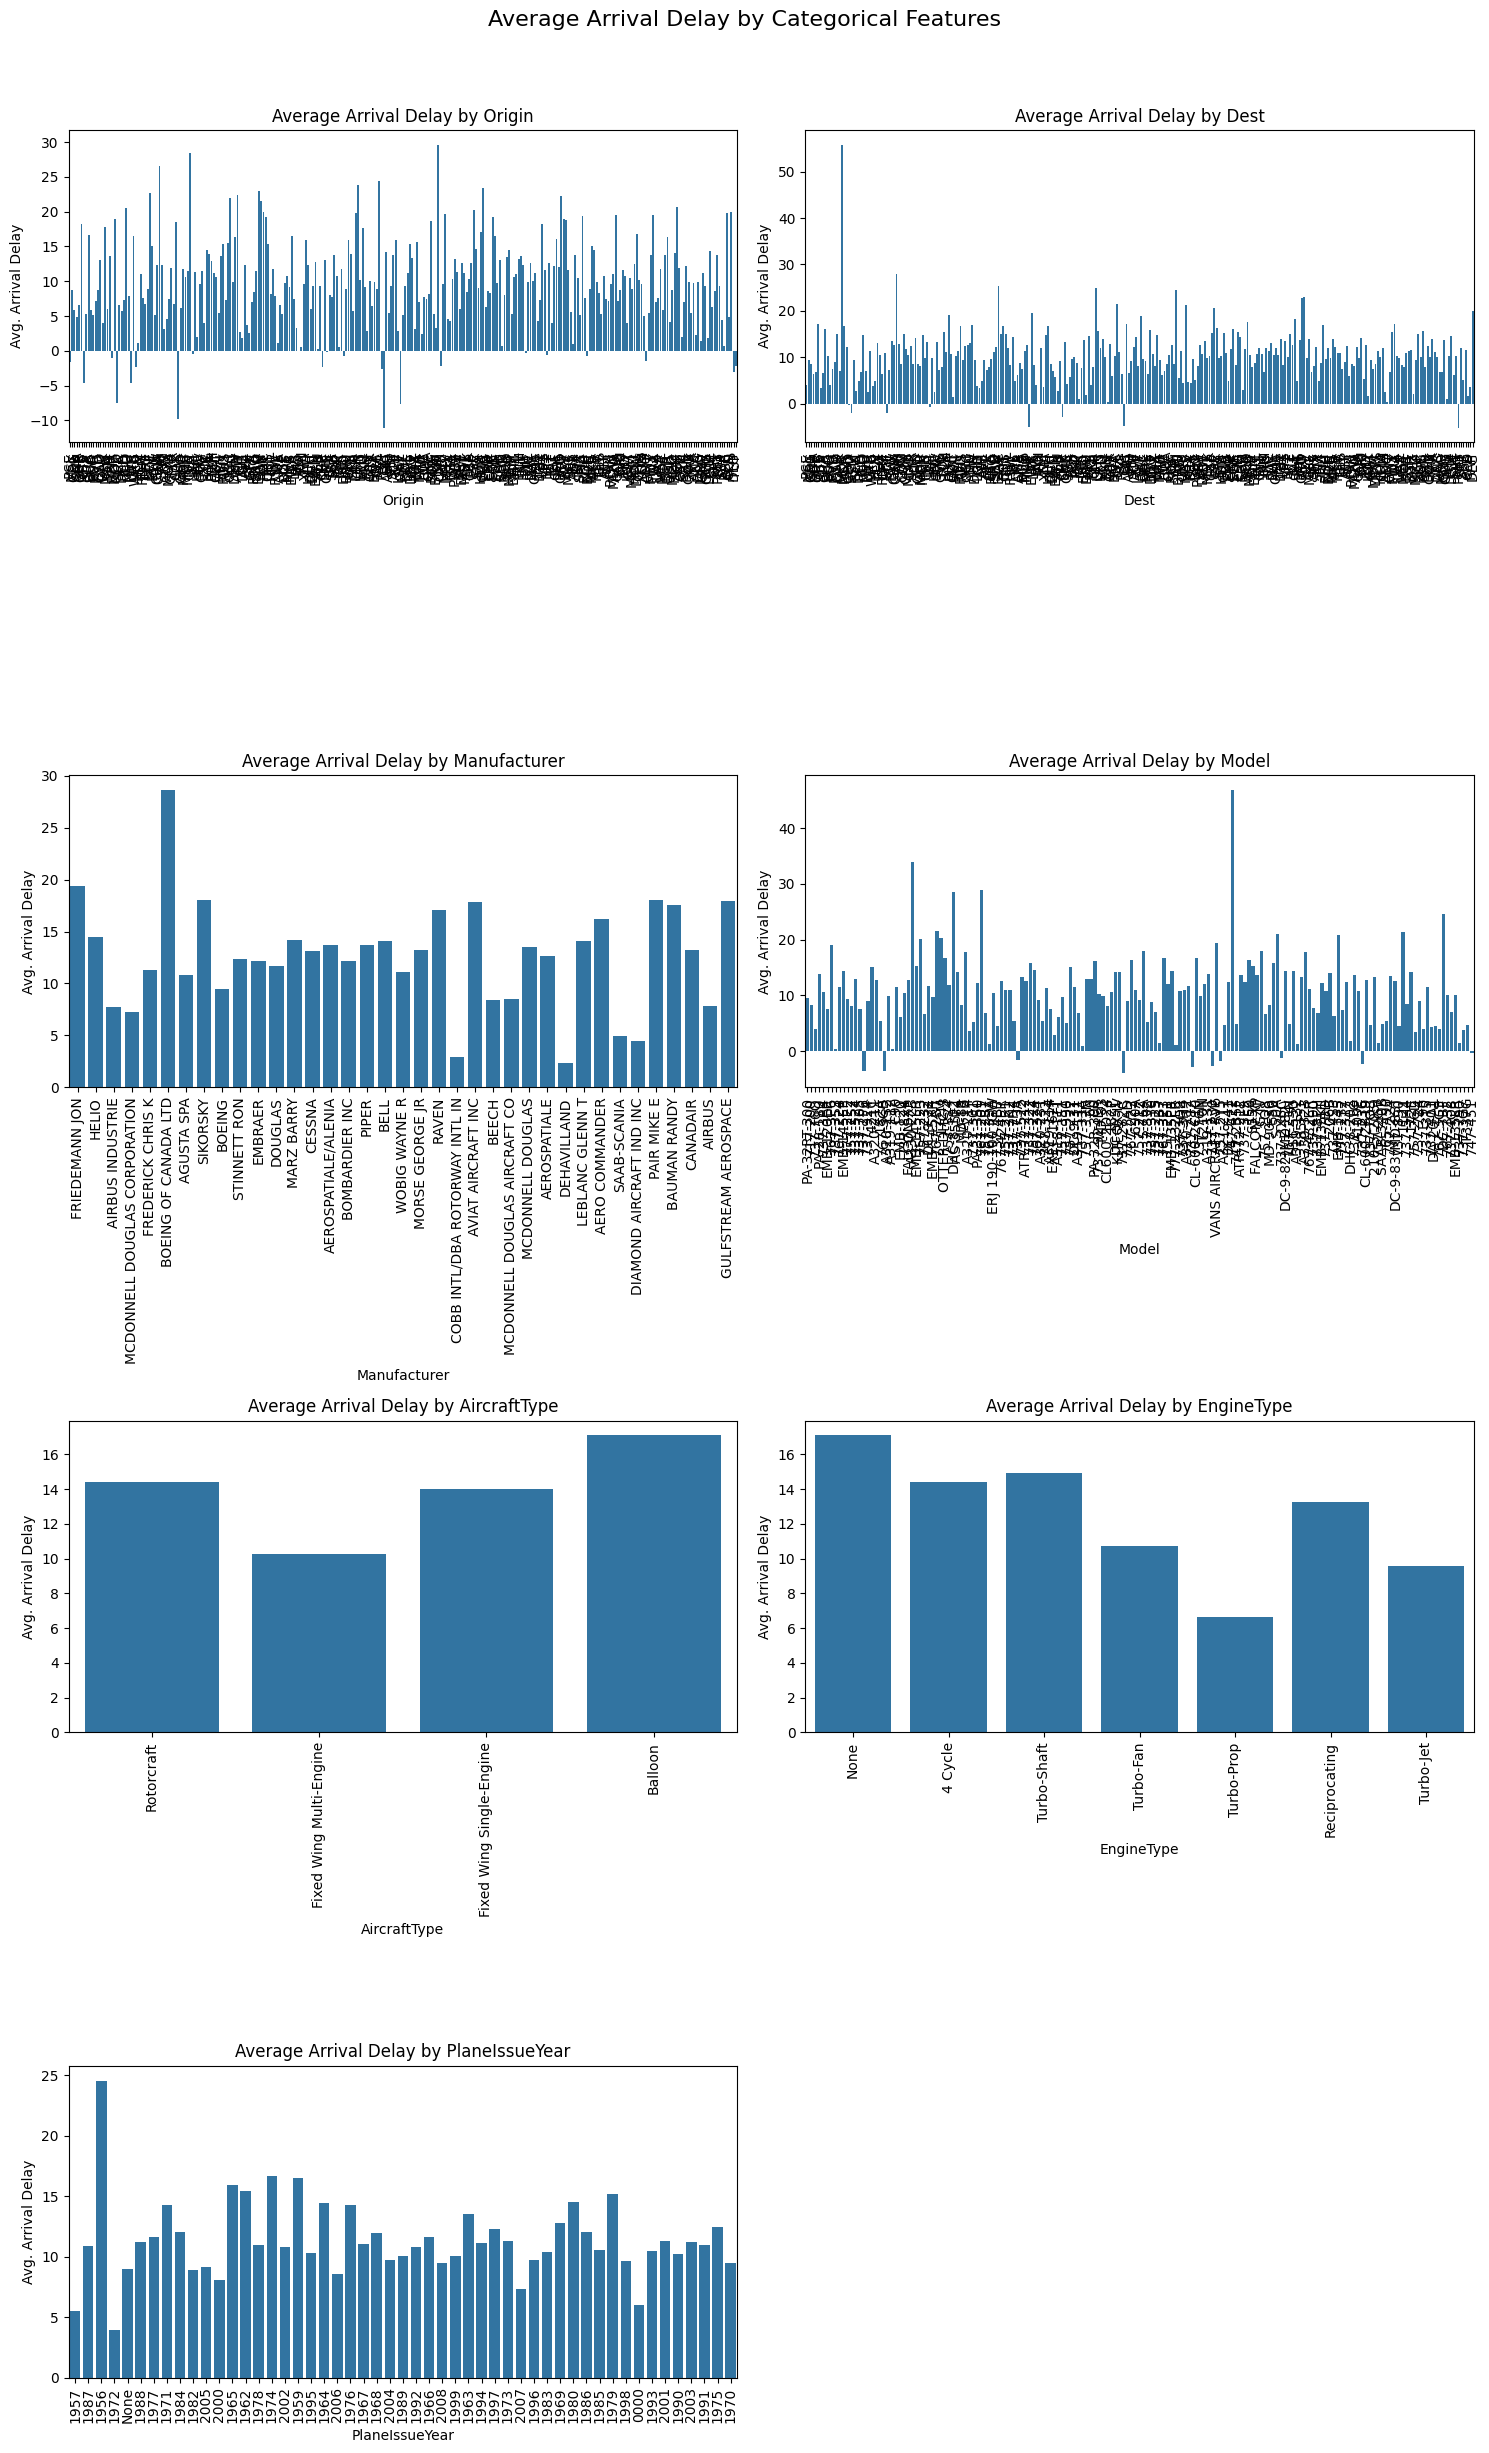

In [20]:
avg_ArrDelay(train_df, categorical_features)

## **Correlation Matrix**

In [21]:
def corr_matrix(data, features_list):
    vector_col = "features_corr"

    vector_assembler = VectorAssembler(inputCols=features_list, outputCol=vector_col)
    df_vector = vector_assembler.transform(data)

    # Compute Correlation Matrix
    correlation_matrix = Correlation.corr(df_vector, vector_col).head()[0]  # Get the DenseMatrix
    correlation_array = correlation_matrix.toArray()
    correlation_df = pd.DataFrame(correlation_array, index=features_list, columns=features_list)
    sns.heatmap(
        correlation_df,
        annot=True,              # Show the correlation values
        fmt=".1f",               # Format to two decimal places
        cmap="coolwarm",         # Color map
        annot_kws={"size": 8}    # Reduce annotation font size
    )
    plt.title("Correlation Matrix Heatmap")
    plt.show()

25/01/06 14:22:34 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/01/06 14:22:34 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
25/01/06 14:22:35 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.


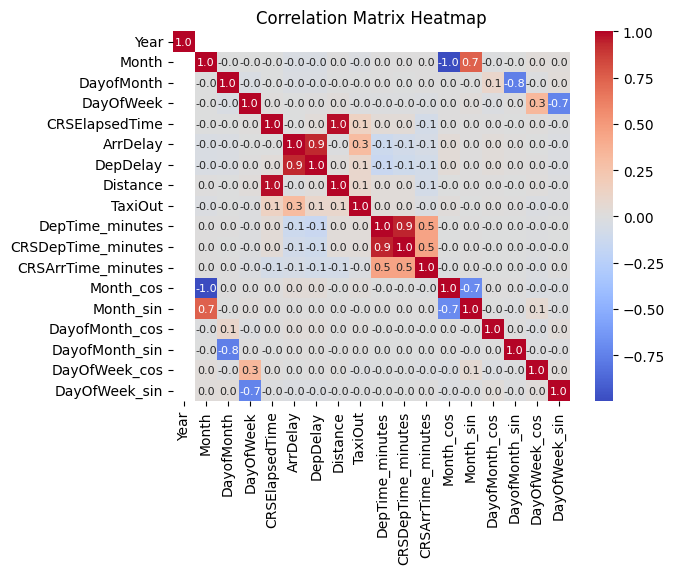

In [22]:
corr_matrix(train_df, numeric_features)

In [ ]:
# =================== 3. Data Processing ===================
def process_data(data, mode):
    """
    Process the dataset: handle missing values and perform feature engineering.

    Args:
        data (DataFrame): Spark DataFrame to process.
        mode (str): Mode of operation ("train" or "predict").

    Returns:
        DataFrame: Processed Spark DataFrame with new features added.
    """
    # Validate the target variable for training mode
    if mode == "train" and "ArrDelay" not in data.columns:
        raise ValueError("The target variable 'ArrDelay' is missing.")

    # Handle missing values
    if mode == "train":
        # Drop rows where the target variable or features are null
        data = data.dropna(subset=["ArrDelay"])

    # Example: Fill null values in specific columns with a default value
    # Replace 'column_name' with actual column names as needed
    # Uncomment this if specific columns require filling
    # data = data.fillna({"column_name": 0})

    # Transform special variables
    # Feature engineering: Create time-based features
    if "DepTime" in data.columns:
        data = data.withColumn("DepHour", (col("DepTime") / 100).cast("int"))  # Extract hour from departure time

    if "FlightDate" in data.columns:
        data = data.withColumn("DayOfWeek", date_format(col("FlightDate"), "u").cast("int"))  # Convert to day of the week

    # Feature engineering: Create flight distance categories
    if "Distance" in data.columns:
        data = data.withColumn(
            "DistanceCategory",
            when(col("Distance") < 500, "Short")  # Short flights
            .when((col("Distance") >= 500) & (col("Distance") < 1500), "Medium")  # Medium flights
            .otherwise("Long")  # Long flights
        )

    return data


In [ ]:
# =================== 4. Feature Engineering ===================
def feature_engineering(data, additional_dataset_path=None):
    """
    Perform feature engineering, including creating new features and optionally integrating additional datasets.

    Args:
        data (DataFrame): Spark DataFrame for feature engineering.
        additional_dataset_path (str): Optional path to an additional dataset for integration.
    
    Returns:
        DataFrame: Enhanced Spark DataFrame with new features.
    """
    # Create new features based on existing columns
    if "existing_column" in data.columns:
        data = data.withColumn("new_feature", col("existing_column") * 2)  # Example transformation

    # Optional: Integrate additional datasets
    if additional_dataset_path:
        try:
            additional_dataset = spark.read.csv(additional_dataset_path, header=True, inferSchema=True)
            
            # Example: Join the datasets on a common column
            if "common_column" in data.columns and "common_column" in additional_dataset.columns:
                data = data.join(additional_dataset, on="common_column", how="left")
        except Exception as e:
            print(f"Error integrating additional dataset: {e}")

    return data


In [ ]:
def build_and_train_model(data, pipeline, model_save_path=None):
    """
    Build, train, evaluate, and optionally save the model using cross-validation with three models.

    Args:
        data (DataFrame): Spark DataFrame with features and labels.
        pipeline (Pipeline): Preprocessing pipeline to use before modeling.
        model_save_path (str): Path to save the trained model (optional).
    
    Returns:
        dict: Evaluation metrics for the trained model.
    """
    # Split data into training and testing sets
    train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

    # Define the models: RandomForestRegressor, DecisionTreeRegressor, LinearRegression
    rf = RandomForestRegressor(featuresCol="features_vector", labelCol="ArrDelay")
    dt = DecisionTreeRegressor(featuresCol="features_vector", labelCol="ArrDelay")
    lr = LinearRegression(featuresCol="features_vector", labelCol="ArrDelay")

    # Initialize metrics dictionary
    all_metrics = {}

    # Evaluate each model separately
    models = [rf, dt, lr]
    model_names = ['Random Forest', 'Decision Tree', 'Linear Regression']
    
    for model, name in zip(models, model_names):
        print(f"Training {name} model...")
        
        # Add the current model to the pipeline
        pipeline.setStages(pipeline.getStages() + [model])

        # Hyperparameter tuning with cross-validation for the current model
        param_grid = ParamGridBuilder() \
            .addGrid(model.numTrees, [10, 50, 100]) if isinstance(model, RandomForestRegressor) else \
            (addGrid(model.maxDepth, [5, 10, 20]) if isinstance(model, DecisionTreeRegressor) else \
            addGrid(model.regParam, [0.1, 0.3, 0.5])) \
            .build()

        evaluator = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="rmse")

        # Set up cross-validation
        cv = CrossValidator(
            estimator=pipeline,
            estimatorParamMaps=param_grid,
            evaluator=evaluator,
            numFolds=5
        )

        # Train the model with cross-validation
        cv_model = cv.fit(train_data)

        # Generate predictions on the test dataset
        predictions = cv_model.transform(test_data)

        # Evaluate the model using multiple metrics
        metrics = {}
        # Root Mean Square Error (RMSE)
        rmse_evaluator = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="rmse")
        metrics['rmse'] = rmse_evaluator.evaluate(predictions)
        print(f"{name} - Root Mean Square Error (RMSE) on test data: {metrics['rmse']}")

        # Mean Absolute Error (MAE)
        mae_evaluator = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="mae")
        metrics['mae'] = mae_evaluator.evaluate(predictions)
        print(f"{name} - Mean Absolute Error (MAE) on test data: {metrics['mae']}")

        # R-Squared (R²)
        r2_evaluator = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="r2")
        metrics['r2'] = r2_evaluator.evaluate(predictions)
        print(f"{name} - R-Squared (R²) on test data: {metrics['r2']}")

        # Store model-specific metrics
        all_metrics[name] = metrics

        # Save the best model if a save path is provided
        if model_save_path:
            cv_model.bestModel.write().overwrite().save(f"{model_save_path}_{name}")
            print(f"Best {name} model saved to: {model_save_path}_{name}")

    return all_metrics


In [ ]:
def predict(data, model_path, output_path):
    """
    Load the trained model and generate predictions for the given data.

    Args:
        data (DataFrame): Spark DataFrame for predictions.
        model_path (str): Path to load the trained model.
        output_path (str): Path to save predictions (CSV).
    
    Returns:
        None
    """
    # Load the trained model
    model = PipelineModel.load(model_path)

    # Make predictions on the input data
    predictions = model.transform(data)

    # Save predictions to the specified output path
    predictions.select("features_vector", "prediction").write.csv(output_path, header=True)
    print(f"Predictions saved to: {output_path}")


In [ ]:
def main():
    """
    Main function to execute the pipeline workflow.
    Accepts command-line arguments for dynamic input/output handling.
    """
    parser = argparse.ArgumentParser(description="Flight Delay Prediction Application")
    parser.add_argument("--mode", type=str, required=True, choices=["train", "predict"], help="Mode: train or predict")
    parser.add_argument("--input", type=str, required=True, help="Path to input CSV file")
    parser.add_argument("--model", type=str, required=True, help="Path to save/load the model")
    parser.add_argument("--output", type=str, help="Path to save predictions (required for predict mode)")

    args = parser.parse_args()

    # Start Spark Session
    spark = SparkSession.builder.appName("FlightDelayPipeline").getOrCreate()

    try:
        # Workflow
        data = load_data(spark, args.input, args.mode)  # Load the dataset
        data = eda(data)
        data = process_data(data, args.mode)        # Preprocess the dataset
        pipeline, _ = feature_engineering(data)        # Perform feature engineering

        if args.mode == "train":
            # Train the model, evaluate it, and optionally save it
            metrics = build_and_train_model(data, pipeline, args.model)
            print(f"Training completed. Evaluation metrics: {metrics}")
        elif args.mode == "predict":
            if not args.output:
                raise ValueError("Output path is required for prediction mode.")
            # Use the trained model to generate predictions
            predict(data, args.model, args.output)

    finally:
        # Stop Spark Session
        spark.stop()

# Add this block to execute the script when running it as a standalone script
if __name__ == "__main__":
    main()


In [ ]:
# spark-submit notebook.py --mode train --input path/to/train.csv --model path/to/save_model
# spark-submit notebook.py --mode predict --input path/to/test.csv --model path/to/save_model --output path/to/predictions